# Model Predictive Control (MPC)
MPC is a form of optimal control. The basic idea behind MPC is that an optimization problem is solved to generate a trajectory of inputs to apply to a system over a specified time horizon. These inputs are applied to a model in order to predict the trajectory of states over the same time horizon that drive the system towards its goal state.
Generally, only the first input calculated is applied to the system and the problem is continually re-solved at each time step. Let's look at each of the pieces needed for an MPC controller.

![image](https://upload.wikimedia.org/wikipedia/commons/thumb/1/11/MPC_scheme_basic.svg/1920px-MPC_scheme_basic.svg.png)

## Model
As the name implies, MPC requires a model that predicts future states based on the current state and provided inputs.
The most common way to get a model is to use the state-variable form of a dynamic system:

$$\dot{x}(t)=f(x(t),u(t))$$
and then discretize it:
$$x_{k+1}=f_d(x_k,u_k)$$


At this point, we should distinguish between linear and non-linear MPC. The literature on MPC is not always consistent on what linear MPC and non-linear MPC (NMPC) mean. At BYU (RAD Lab and MAGICC Lab), we have generally said that the distiction is based on whether this model, $\dot{x}(t)=f(x(t),u(t))$, is linear or non-linear throughout the optimization. This means if a non-linear model is linearized in some way during the optimization over a single time horizon, we consider it linear MPC even though the system has non-linear dynamics. We only call it NMPC if the optimization problem is using non-linear dynamics to propagate the state over the time horizon. If this doesn't quite make sense now, it should after we reach the optimization portion of MPC.

As you can imagine, using non-linear dynamics during the optimization requires much more computational effort and takes more time to solve. It is common in the literature to just use linear MPC if you need a lot of speed. So far, I have only dealt with linear MPC and will focus on that in this notebook. Linearization can be done around any point, but there are added complexities if you linearize around a non-equilibrium point. A system is in equilibrium when $\dot{x}=f(x_{eq},u_{eq})=0$, meaning that your states won't change from where they are given the equilibrium input. Linearizing equations around some equilibrium point, $eq$, in state-variable form allows you to generate a state-space model with $\tilde{x}=x-x_{eq}$. Let's do that with a mulitivariate Taylor series expansion:

\begin{eqnarray}
\dot{x}(t) &\approx& f(x_{eq},u_{eq}) + \left.\frac{\partial f}{\partial x}\right\vert_{eq}\left(x(t)-x_{eq}\right) + \left.\frac{\partial f}{\partial u}\right\vert_{eq}\left(u(t)-u_{eq}\right) \\
&=& \left.\frac{\partial f}{\partial x}\right\vert_{eq}\tilde{x}(t) + \left.\frac{\partial f}{\partial u}\right\vert_{eq}\tilde{u}(t) \\
&=& A\tilde{x}(t)+B\tilde{u}(t)
\end{eqnarray}

This gives us the model we usually use:

$$\dot{\tilde{x}}(t) = A\tilde{x}(t)+B\tilde{u}(t)$$

Because we linearized about an equilibrium point, $\dot{\tilde{x}}=\dot{x}-f(x_{eq},u_{eq})=\dot{x}$. This is not true when linearizing about a non-equilibrium point and that causes issues if you aren't careful, but that is a topic for another day. With the above model, we can perform a simple forward difference numeric integration in order to discretize it:

\begin{eqnarray}
\frac{\tilde{x}_{k+1}-\tilde{x}_k}{\Delta t} &=& A\tilde{x}_k+B\tilde{u}_k \\
\tilde{x}_{k+1} &=& \tilde{x}_k + \Delta t\left(A\tilde{x}(t)+B\tilde{u}_k\right) \\
&=& (I+\Delta tA)\tilde{x}_k + (\Delta tB)\tilde{u}_k 
\end{eqnarray}

This gives us the discretized version:
$$\tilde{x}_{k+1}=A_d\tilde{x}_k+B_d\tilde{u}_k$$

or the same equation expanded out:

$$x_{k+1}=A_d(x_k-x_{eq})+B_d(u_k-u_{eq})+x_{eq}$$

## Time Horizon
There are 2 pieces of information that affect how far into the future a state trajectory will be predicted: the time step ($t_s$) and the number of steps ($N$). The length of the horizon is then $t_s*N$. So if we look 10 steps into the future and discretize the system at 0.1s, then the length of the horizon will be $0.1*10=1s$.

One iteration of MPC requires knowledge of the current state, $x_0$, and the optimization solver will generate an input trajectory, $u_0,u_1,...,u_N$, that the model will use to predict a state trajectory, $x_1,x_2,...,x_{N+1}$. Let's visually walk through a couple of steps.

$$x_1=Ax_0+Bu_0$$

Here, $x_0$ needs to be known and provided to the optimization solver to produce $u_0$.

$$x_2=Ax_1+Bu_1$$

We can solve the first equation for $x_1$ and the optimization solver will use that to generate $u_1$. You can see how this second equation could also be written entirely in terms of $x_0$ by substituting the first equation into the second:

\begin{eqnarray}
x_2 &=& A(Ax_0+Bu_0)+Bu_1 \\
    &=& A^2x_0 + ABu_0 + Bu_1
\end{eqnarray}

Now let's solve for $x_3$.

$$x_3=Ax_2+Bu_2$$

Let's do a similar substitution as before:

\begin{eqnarray}
x_3 &=& A(A^2x_0 + ABu_0 + Bu_1)+Bu_2 \\
    &=& A^3x_0 + A^2Bu_0 + ABu_1 + Bu_2
\end{eqnarray}

Continuing this pattern we can solve for $x_n$ only in terms of $x_0$ and the inputs.

$$x_N=A^Nx_0+\sum_{j=0}^{N-1}A^{N-1-j}Bu_j$$

We know $x_0$. Also, A and B are known and unchanging because it is a linear model. So the only 2 unknowns are the input trajectory and the predicted future state trajectory, which is what the optimization problem finds.

## Optimization
To this point, we have talked about how the optimization solver generates a trajectory of inputs to produce a desirable trajectory of outputs. Let's take a look at how the optimization does that. There are 3 main pieces to the optimization problem: the cost function, constraints, and parameters.

### Cost Function
As with any optimization problem, we need to come up with some function to minimize or maximize. This function can have several names, such as objective function or loss function. With MPC, it is usually referred to as the cost function. In general with controls, we want to minimize error. Error is defined as the difference in our desired state and current state. In order to have one global minimum, we want the cost function to be quadratic. For scalars, a quadratic function is $f(x)=\alpha x^2$ where $\alpha$ is positive. For vectors, a quadratic function looks like $f(\mathbf{x})=\mathbf{x}^TQ\mathbf{x}$ where Q is a semi-positive definite matrix (but non-zero). Q is generally a diagonal matrix of scalar weights for each state. So here is a basic cost function that would minimize the error in states:

$$J=\sum_{k=1}^{N+1}(x_k-x_{des})^TQ(x_k-x_{des})$$

The cost function can really be any function of states and inputs. Sometimes, one might want to minimize the amount of energy used by the system (e.g. prolong battery life). This can be done by adding a quadratic cost on the inputs:

$$J_u=\sum_{k=0}^{N}u_k^TRu_k$$

If your inputs were motor commands to keep a multirotor vehicle in the air, you might want to add cost on the difference in applied inputs and equilibrium inputs:

$$J_u=\sum_{k=0}^{N}(u_k-u_{eq})^TR(u_k-u_{eq})$$

Another common idea is to have conservative inputs that don't change very fast. This can be accomplished by adding a cost to the change in inputs from step to step:

$$J_u=\sum_{k=0}^{N-1}(u_{k+1}-u_k)^TR(u_{k+1}-u_k)$$

Having a cost on error in states is probably required to control the sytem, but the formulation of the cost from inputs will likely vary from problem to problem. Currently, I use a cost function that does not consider the inputs at all.

### Constraints
If all we had was a cost function with no constraints, the optimization would basically tell you "just teleport to where you want to go." Unfortunately, we can't tell our system to do that so the optimization needs some constraints to tell it how our system is capable of moving. The most important constraint, then, is the model that we came up with for the dynamic system.

$$x_{k+1}=Ax_k+Bu_k \ \ \ \forall k \in 0,1,...,N$$

With a cost function in the form $\sum x^TQx+u^TRu$ and the dynamic model constraint from the line above, MPC would act the same way as LQR. So if you want your optimization problem to look like that, you might consider using LQR instead; LQR has a closed-loop solution that solves this optimization really fast. MPC differs from LQR if you wish to add additional constraints or costs.

So what are some other constraints/costs we might want to use? We already saw 1 example: don't let inputs change very much from step to step. Granted, we did use this as an example cost; however, we can strictly limit the change in inputs from step to step if we use a constraint:

$$-\Delta u_{max} \le u_{k+1}-u_k \le \Delta u_{max}$$

You should now be able to see that some outcomes we want can be achieved as either a constraint or a cost, depending on how strictly we want to accomplish that outcome.

Another common constraint is the saturation limits for states and inputs. Perhaps a state is a robot arm joint angle that can only move between a specific range of angles. Or maybe you have an input of thrust from a propellor that has a physical max and can't be negative. These saturation limits can be provided to the optimization solver so that it theoretically knows how to provide optimal inputs that are dynamically achievable. Here is what the saturation constraints would look like:

$$x_{min} \le x_k \le x_{max}$$

$$u_{min} \le u_k \le u_{max}$$

There are surely other clever constraints that could be used based on a given problem. Just note that the constraints are written as functions of states and inputs. These funtions will most often be linear otherwise the optimization is much harder to solve and might not produce real-time solutions. It is also worth noting that equality constraints are easier/faster for the optimization to use because inequalities provide a much larger search area.

###  Parameters
Parameters are pretty simple; they are values you provide the optimization solver that stay constant for that solution. Examples are $A,B,N,x_0,x_{min},x_{max},u_{min},u_{max},$ and any others you might have specified in your cost function or constraints. With MPC, these parameters are constant for a single time horizon. After the first input is applied, the optimization will be solved again and can/will have new values for the parameters. $x_0$ is a value that will change almost every time, because the previous input you apply will likely cause you to move. If you are linearizing a non-linear model then $A$ and $B$ can be updated at each time step as well.

### Mass Spring Damper Example
Governing dynamic equations:

$$m\ddot{x}+b\dot{x}+kx=f$$

Find equilibrium point(s):

$$f_{eq}=kx_{eq}$$

Notice how equilibrium force depends on the location of the mass. We don't have to worry too much about this because it is already a linear system, meaning we can linearize about any point and still model the system perfectly. Let's choose to use $x_{eq}=f_{eq}=0$ and not worry about these values.

Get into state-variable form:

\begin{eqnarray}
\dot{x}  &=& \dot{x} \\
\ddot{x} &=& -\frac{b}{m}\dot{x} - \frac{k}{m}x + \frac{1}{m}f
\end{eqnarray}

Let $\mathbf{x}=[x, \dot{x}]^T$ and $\mathbf{u}=[f]$, then the state-space form is the following:

$$
\mathbf{\dot{x}} = 
\begin{bmatrix} 0 & 1 \\ -\frac{k}{m} & -\frac{b}{m} \end{bmatrix}
\mathbf{x} +
\begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix} u
$$

In [11]:
import numpy as np
import control as ctrl

m = 5.0
k = 3.0
b = 0.5

ts = 0.05

A = np.array([[0,1],[-k/m,-b/m]])
B = np.array([[0],[1/m]])
C = np.eye(2)
D = np.zeros((C.shape[0],1))
sys = ctrl.ss(A,B,C,D)
sys_d = ctrl.c2d(sys, ts)

Ad = np.array(sys_d.A)
Bd = np.array(sys_d.B)

In [12]:
import cvxpy as cp
from time import time as now

x0 = np.array([0,0])
x_des = np.array([1,0])

n = 2
m = 1
T = 10

Q = np.diag([1,0.01])
# Q = np.diag([1,0.1])
# Q = np.diag([1,0.2])
# Q = np.diag([1,0.11])

R = 0
# R = 0.01
# R = 0.0001

pos = []
pos.append(x0.item(0))

inputs = []

tf = 10
t = 0
time = []
time.append(t)
begin = now()
while t <= tf:
    # calculate optimal control
    x = cp.Variable((n, T+1))
    u = cp.Variable((m, T))
    cost = 0
    constr = []
    for i in range(T):
        cost += cp.quad_form(x[:,i+1]-x_des,Q) # cost on error in states
        cost += cp.sum_squares(u[:,i])*R # cost on input
#         constr += [x[:,i+1] == Ad @ x[:,i] + Bd * u[:,i],
        constr += [x[:,i+1] == Ad @ (x[:,i]-x_des) + Bd * (u[:,i]-3) + x_des,
                  u[:,i] >= 0, u[:,i] <=3]
    constr += [x[:,0] == x0]

    prob = cp.Problem(cp.Minimize(cost), constr)
    prob.solve()
    optimal_u = u[:,0].value.item(0)
    inputs.append(optimal_u)
    
    # apply optimal control
#     x0 = Ad @ x0.reshape(2,1) + Bd * optimal_u
    x0 = Ad @ (x0-x_des).reshape(2,1) + Bd * (optimal_u-3) + x_des.reshape(2,1)
    pos.append(x0.item(0))
    x0 = np.array([x0.item(0),x0.item(1)])
    
    # increment time
    t += ts
    time.append(t)

end = now()
print('elapsed time: ',end-begin)
print('final position:\t',x0.item(0))
print('final input:\t',optimal_u)

elapsed time:  12.545670986175537
final position:	 0.9959911211525313
final input:	 3.0


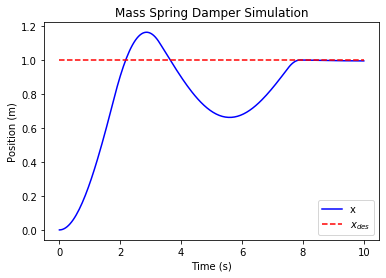

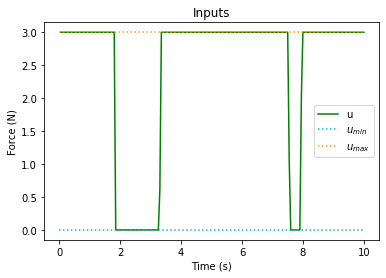

In [10]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(time, pos, 'b', label='x')
plt.plot([0,tf],[1,1]*x_des.item(0), 'r--', label='$x_{des}$')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Mass Spring Damper Simulation')
plt.legend(loc='lower right')

plt.figure(2)
plt.plot(time[1:], inputs, 'g', label='u')
plt.plot([0,tf],[0,0], 'c:', label='$u_{min}$')
plt.plot([0,tf],[3,3], color='orange', linestyle=':', label='$u_{max}$')
plt.xlabel('Time (s)')
plt.ylabel('Force (N)')
plt.title('Inputs')
plt.legend()

plt.show()

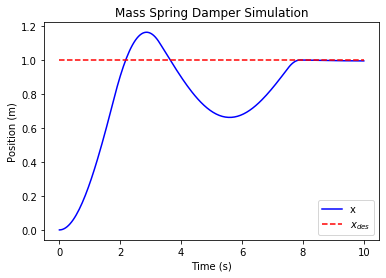

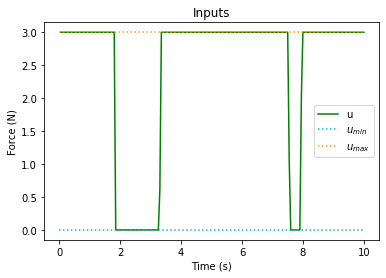

In [109]:
plt.figure(1)
plt.plot(time, pos, 'b', label='x')
plt.plot([0,tf],[1,1]*x_des.item(0), 'r--', label='$x_{des}$')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Mass Spring Damper Simulation')
plt.legend(loc='lower right')

plt.figure(2)
plt.plot(time[1:], inputs, 'g', label='u')
plt.plot([0,tf],[0,0], 'c:', label='$u_{min}$')
plt.plot([0,tf],[3,3], color='orange', linestyle=':', label='$u_{max}$')
plt.xlabel('Time (s)')
plt.ylabel('Force (N)')
plt.title('Inputs')
plt.legend()

plt.show()